This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [23]:
figname = '../figures/fig_params'

In [9]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-03-27
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 1.0, 'contrast': 1.0, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.1, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-27', 'seed': 2019, 'N_cv': 8, 'do_compute': True}
Overwriting train.py
The watermark extension is already loaded. To 

In [3]:
%%writefile params.py
import os
import torch
from main import init, MetaML
from where import Where as ML
from what import WhatNet
        
import sys
opts = dict(filename='../data/2019-03-16', verbose=0, log_interval=0, do_compute=False  if len(sys.argv) > 1 else True)
#opts = dict(filename='debug', verbose=0, log_interval=0)

print(50*'-')
print(' parameter scan')
print(50*'-')

if True:
    args = init(**opts)
    args.filename = '../data/2019-03-19'
    filename_train = args.filename + '_train.pt'
    if not(os.path.isfile(filename_train + '_lock')):
        open(filename_train + '_lock', 'w').close()
        print(50*'-')
        print('Default parameters')
        print(50*'-')
        from where import Where as ML
        from what import WhatNet
        ml = ML(args)
        ml.train(path=filename_train)
        # ml.main(path=args.filename)
        os.remove(filename_train + '_lock')

if True:
    args = init(**opts)
    mml = MetaML(args)
    if torch.cuda.is_available():
        mml.scan('no_cuda', [True, False])

    args = init(**opts)
    mml = MetaML(args)
    mml.scan('bias_deconv', [True, False])

results = {}
    
def update_results(results, parameter, accuracies):
    if not parameter in results.keys(): results[parameter] = dict(value=[], accuracy=[])
    for value in accuracies.keys():
        results[parameter]['value'].append(value)
        results[parameter]['accuracy'].append(accuracies[value][:-1].mean()*100)
    return results
            
for base in [2, 8] if not args.filename == '../data/debug' else [2]:
    print(50*'-')
    print(' base=', base)
    print(50*'-')

    print(50*'-')
    print(' parameter scan : data')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args, base=base)
    for parameter in ['sf_0', 'B_sf', 'offset_std' , 'noise']: #, 'contrast'
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        
    print(50*'-')
    print(' parameter scan : network')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['dim1',
                      'bn1_bn_momentum',
                      'dim2',
                      'bn2_bn_momentum',
                      'p_dropout']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(' parameter scan : learning ')
    args = init(**opts)
    mml = MetaML(args, base=base)
    print(50*'-')
    print('Using SGD')
    print(50*'-')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        mml.parameter_scan(parameter)
    print(50*'-')
    print('Using ADAM')
    print(50*'-')
    args = init(**opts)
    args.do_adam = True
    mml = MetaML(args, tag='adam')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(50*'-')
    print(' parameter scan : retina')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['N_theta',
                      'N_azimuth',
                      'N_eccentricity',
                      'rho']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        

Overwriting params.py


In [4]:
%run params.py scan

--------------------------------------------------
 parameter scan
--------------------------------------------------
scanning over bias_deconv = [True, False]
For parameter bias_deconv = True ,  Accuracy=72.7% +/- 0.3%  in 13946.4 seconds
For parameter bias_deconv = False ,  Accuracy=73.2% +/- 0.0%  in 11114.9 seconds
--------------------------------------------------
 base= 2
--------------------------------------------------
--------------------------------------------------
 parameter scan : data
--------------------------------------------------
scanning over sf_0 = [0.1        0.11892071 0.14142136 0.16817928 0.2        0.23784142
 0.28284271 0.33635857 0.4       ]
For parameter sf_0 = 0.100 ,  Accuracy=66.6% +/- 0.3%  in 12092.7 seconds
For parameter sf_0 = 0.119 ,  Accuracy=67.3% +/- 0.1%  in 12423.9 seconds
For parameter sf_0 = 0.141 ,  Accuracy=68.7% +/- 0.0%  in 12041.9 seconds
For parameter sf_0 = 0.168 ,  Accuracy=71.2% +/- 0.4%  in 12207.2 seconds
For parameter sf_0 = 0.2

KeyboardInterrupt: 

In [10]:
print(accuracies)

{12: array([5.34200000e-01, 5.34200000e-01, 5.34200000e-01, 5.34200000e-01,
       5.34200000e-01, 5.34200000e-01, 5.34200000e-01, 5.34200000e-01,
       5.35810416e+03]), 14: array([6.46000000e-01, 6.46000000e-01, 6.46000000e-01, 6.46000000e-01,
       6.46000000e-01, 6.46000000e-01, 6.46000000e-01, 6.46000000e-01,
       6.33064747e+03])}


In [11]:
results['sf_0']['value'],  results['sf_0']['accuracy']

([0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4],
 [66.62750000000001,
  67.2825,
  68.67750000000001,
  71.18749999999999,
  72.61999999999999,
  74.1175,
  75.1625,
  76.08250000000001,
  76.5725])

## parameter scan

---> sf_0


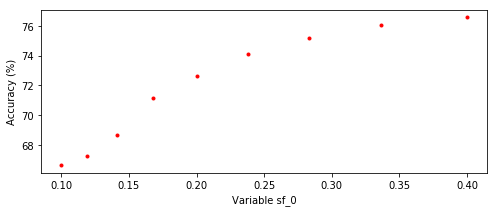

---> B_sf


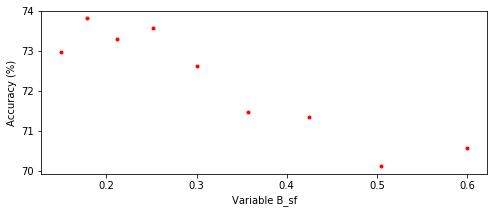

---> offset_std


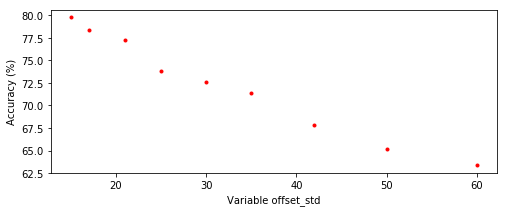

---> noise


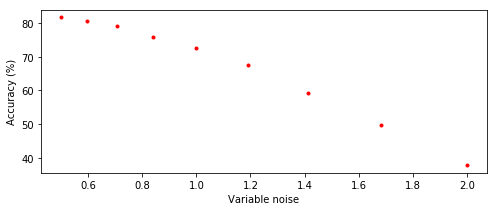

---> dim1


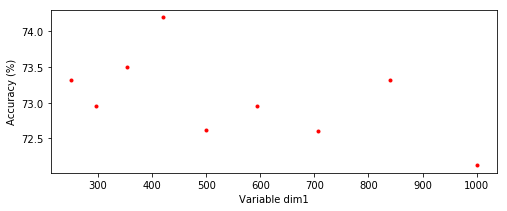

---> bn1_bn_momentum


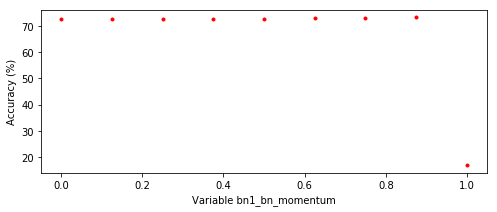

---> dim2


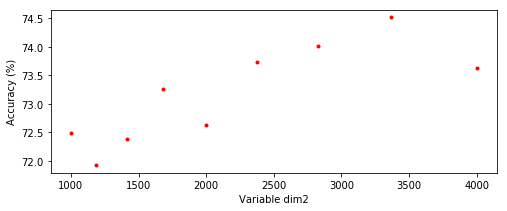

---> bn2_bn_momentum


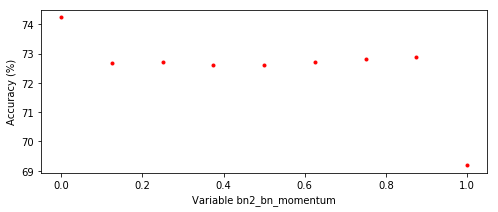

---> p_dropout


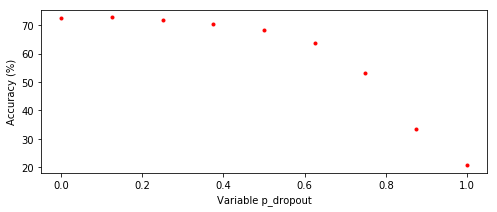

---> lr


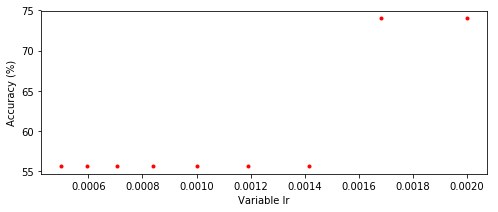

---> momentum


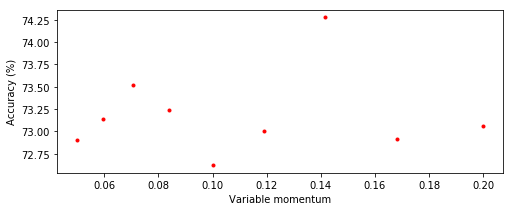

---> minibatch_size


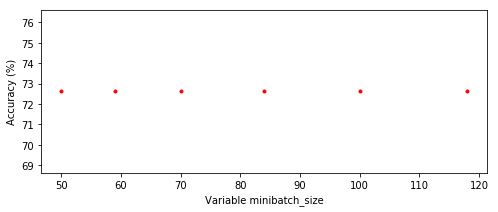

---> epochs


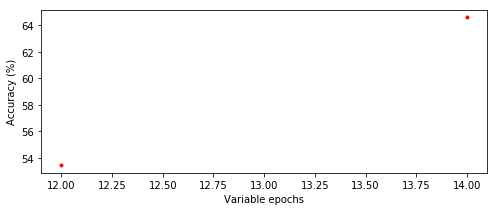

In [12]:
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(results[parameter]['value'], 
            results[parameter]['accuracy'], 'r.')
    plt.xlabel('Variable ' +  parameter)
    plt.ylabel('Accuracy (%)')

    plt.show()

In [13]:
results['sf_0']

{'value': [0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4],
 'accuracy': [66.62750000000001,
  67.2825,
  68.67750000000001,
  71.18749999999999,
  72.61999999999999,
  74.1175,
  75.1625,
  76.08250000000001,
  76.5725]}

In [14]:
def plot_accuracy(value, accuracy, xmin=10, fig=None, ax=None):
    if fig is None: fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(accuracy, value, "o", color='blue')
    ax.hlines(y=value, xmin=accuracy, xmax=100, color='red')
    ax.hlines(y=value, xmin=xmin, xmax=accuracy, color='skyblue')

    plt.ylabel(parameter.capitalize())
    #print( results[parameter]['value'] )
    #print( np.min([np.float(k) for k in results[parameter]['value']]))
    #ax.vlines(100, np.min(results[parameter]['value']), np.max(results[parameter]['value']), 'k', label='max')
    plt.xlabel('Accuracy (%)')
    # Only draw spine between the y-ticks
    #ax.spines['left'].set_bounds(-1, 1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return fig, ax

---> sf_0


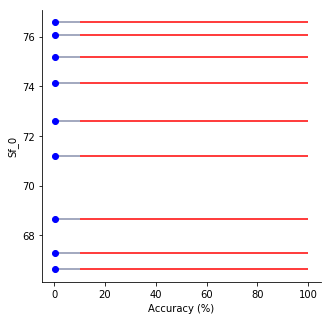

---> B_sf


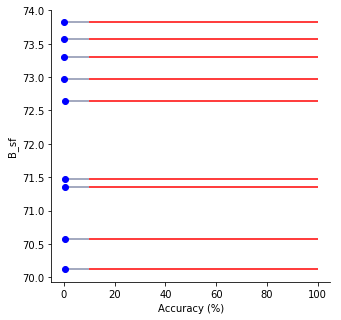

---> offset_std


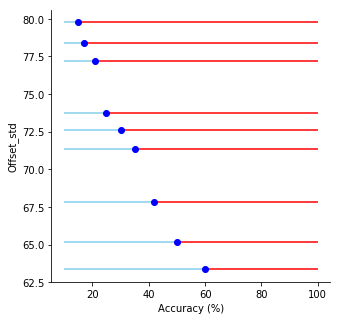

---> noise


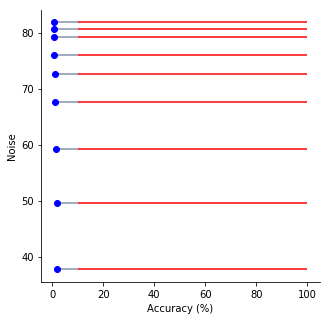

---> dim1


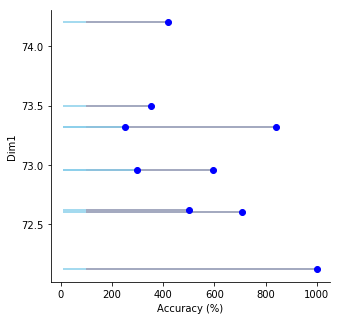

---> bn1_bn_momentum


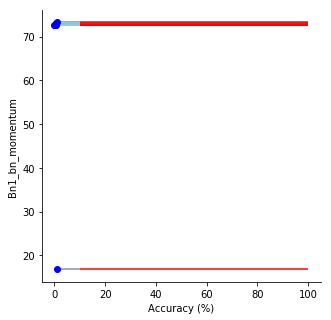

---> dim2


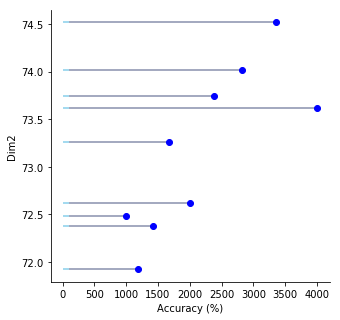

---> bn2_bn_momentum


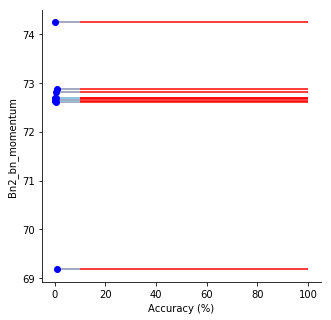

---> p_dropout


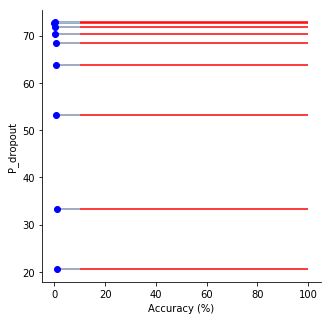

---> lr


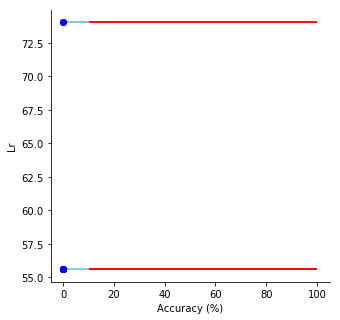

---> momentum


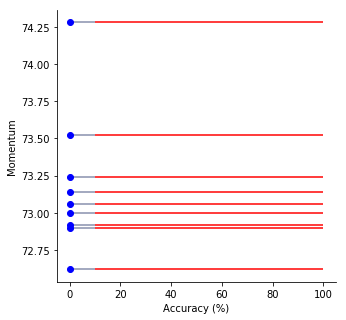

---> minibatch_size


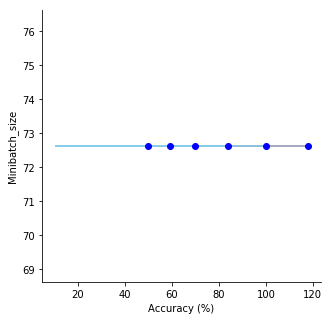

---> epochs


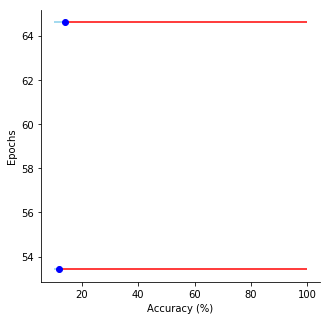

In [22]:
figname_ = 'accuracy_'
figname_ = ''

tex = ''
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plot_accuracy(results[parameter]['accuracy'], results[parameter]['value'])
    plt.show()
    if not figname_ == '':
        fig_dir = './'
        fig_ext = '.pdf'
        fname = figname_ + parameter + fig_ext
        tex += "\includegraphics[width=.0666\linewidth]{"+ fname + "} \n"
        fig.savefig(os.path.join(fig_dir, fname),
                bbox_inches='tight', pad_inches=0)
print(tex)

# summary


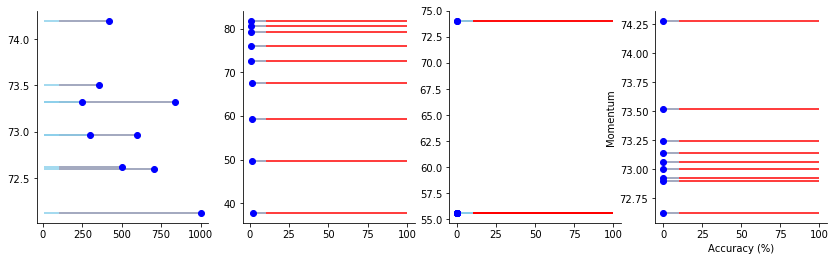

In [24]:
parameters = ['dim1', 'noise', 'lr', 'momentum']
fig, axs = plt.subplots(1, len(parameters), figsize = (figwidth, figwidth/len(parameters)*1.1))

for ax, parameter in zip(axs, parameters):
    fig, ax = plot_accuracy(results[parameter]['accuracy'], results[parameter]['value'], xmin=10, fig=fig, ax=ax)

fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.15)

In [25]:
figname + '.pdf'

'../figures/fig_params.pdf'

# post-processing

In [26]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

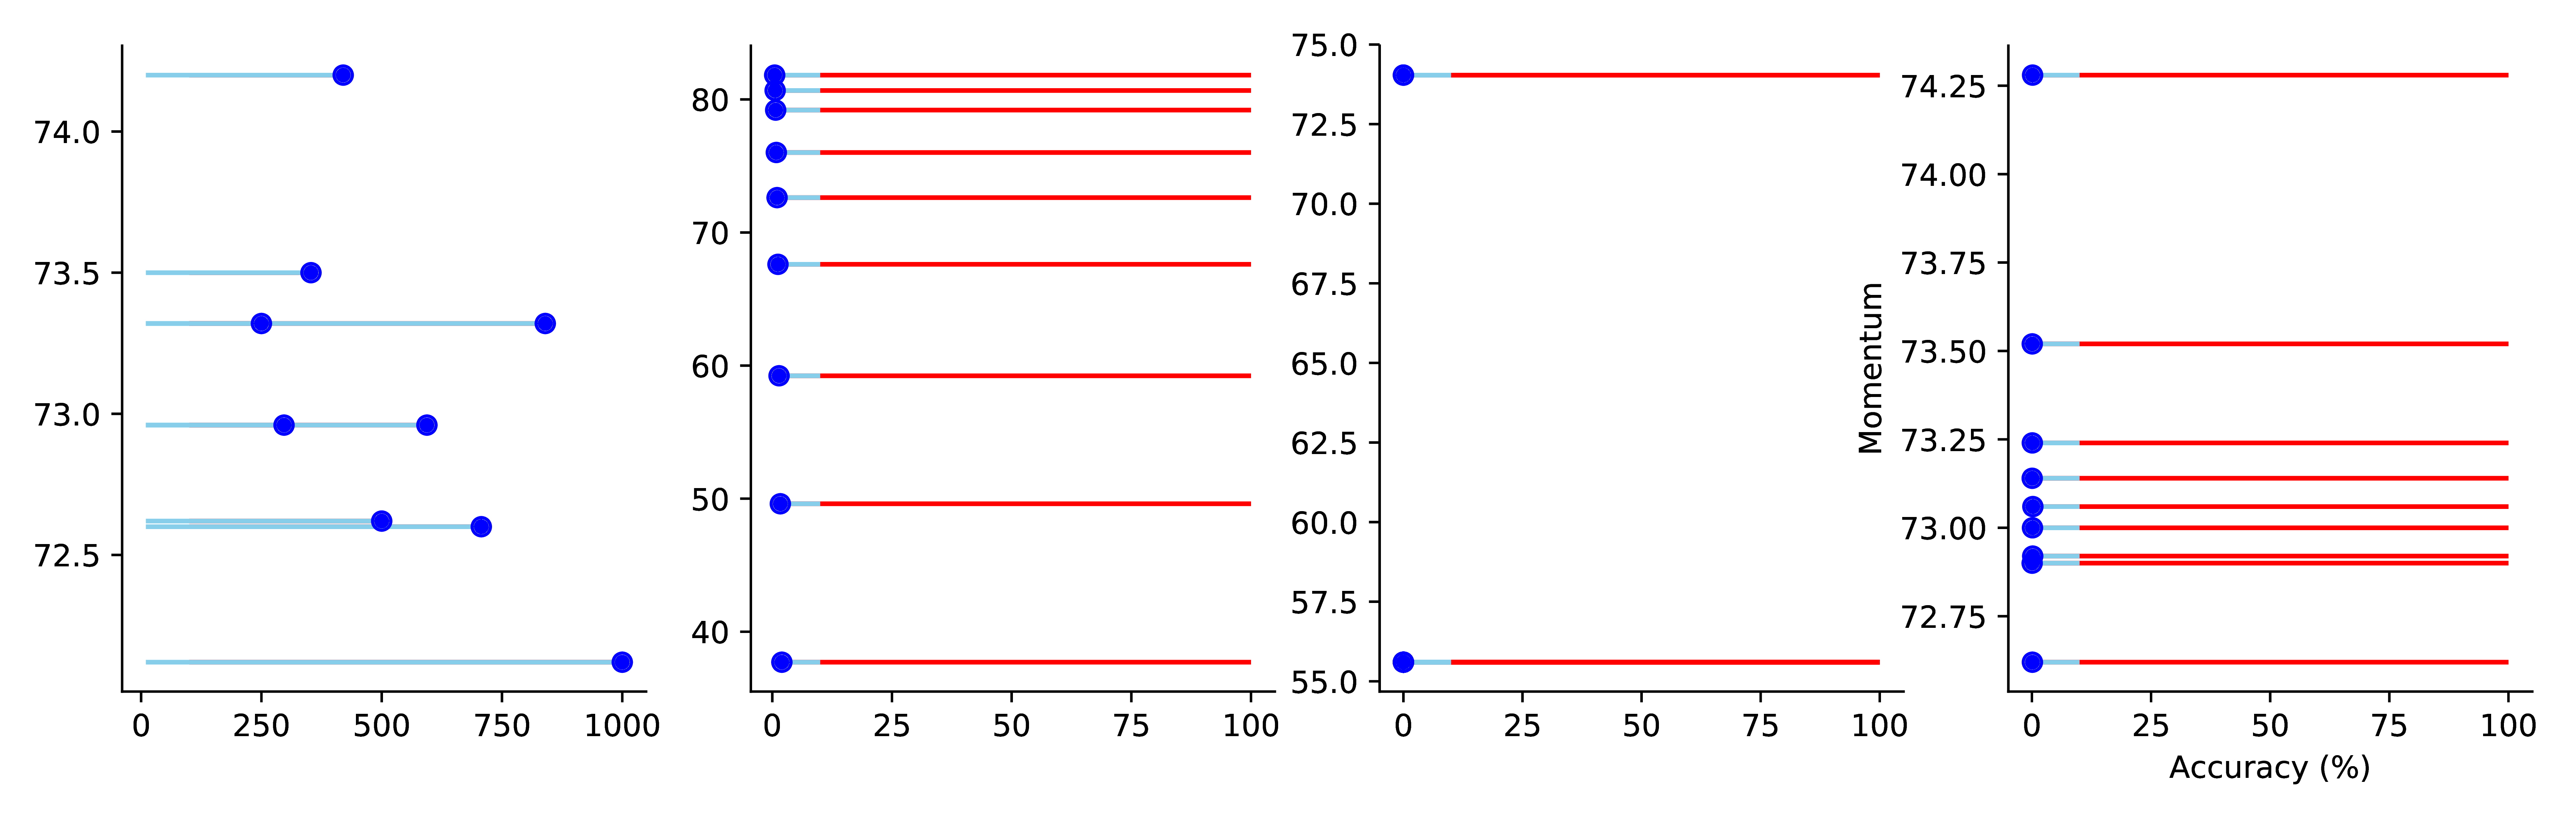

In [27]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [28]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  733927 Mar 27 15:54 ../figures/fig_params.jpg
-rw-r--r--  1 laurentperrinet  staff   14859 Mar 27 15:54 ../figures/fig_params.pdf
-rw-r--r--  1 laurentperrinet  staff  103307 Mar 27 15:54 ../figures/fig_params.png
